In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.dates as mdates
from datetime import datetime, timedelta

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model

Base = automap_base()

# reflect the tables

Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
# Get the class names as a list of strings
class_names = [class_name for class_name in Base.classes.keys()]

# Display the class names
print(class_names)

['measurement', 'station']


In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

print(most_recent_date)



('2017-08-23',)


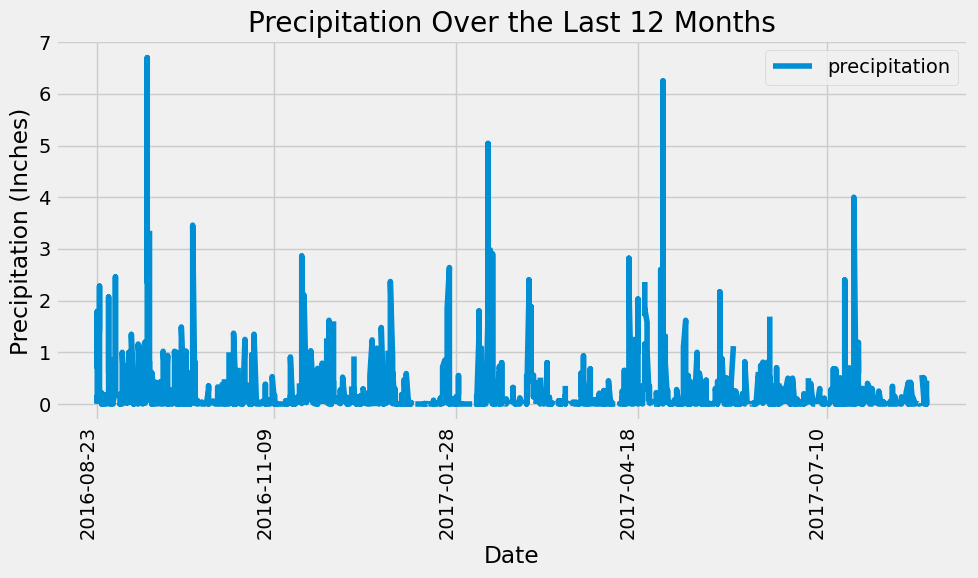

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]

# Calculate the date one year from the last date in data set
one_year_ago = datetime.strptime(most_recent_date, '%Y-%m-%d') - timedelta(days=366)

# Perform a query to retrieve the date and precipitation scores
precipitation_data = session.query(Measurement.date, Measurement.prcp)\
    .filter(Measurement.date >= one_year_ago)\
    .order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and explicitly set the column names
df = pd.DataFrame(precipitation_data, columns=['date', 'precipitation'])
df['date'] = pd.to_datetime(df['date'])

# Sort the dataframe by date
df.sort_values('date', inplace=True)

# Plot the results using the DataFrame plot method
df.plot(x='date', y='precipitation', figsize=(10, 6), label='precipitation', legend=True)

# We don't need custom_dates since we plot every date now
plt.xlabel('Date')
plt.ylabel('Precipitation (Inches)')
plt.title('Precipitation Over the Last 12 Months')
plt.xticks(df['date'][::500], rotation=90)
plt.tight_layout()  # Make sure everything fits without overlapping
plt.show()


In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_statistics = df['precipitation'].describe()
summary_statistics_df = summary_statistics.to_frame()
summary_statistics_df



,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).scalar()

print([(total_stations,)])


[(9,)]


In [13]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
most_active_stations = session.query(Measurement.station, func.count(Measurement.station))\
    .group_by(Measurement.station)\
    .order_by(func.count(Measurement.station).desc())\
    .all()

# List the stations and their counts in descending order.
most_active_stations


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station_id = most_active_stations[0][0]

# Query to calculate the lowest, highest, and average temperature for the most active station
temperature_stats = session.query(
    func.min(Measurement.tobs),
    func.max(Measurement.tobs),
    func.avg(Measurement.tobs)
).filter(Measurement.station == most_active_station_id).all()

# The result will be in the format [(min_temp, max_temp, avg_temp)]
print(temperature_stats)


[(54.0, 85.0, 71.66378066378067)]


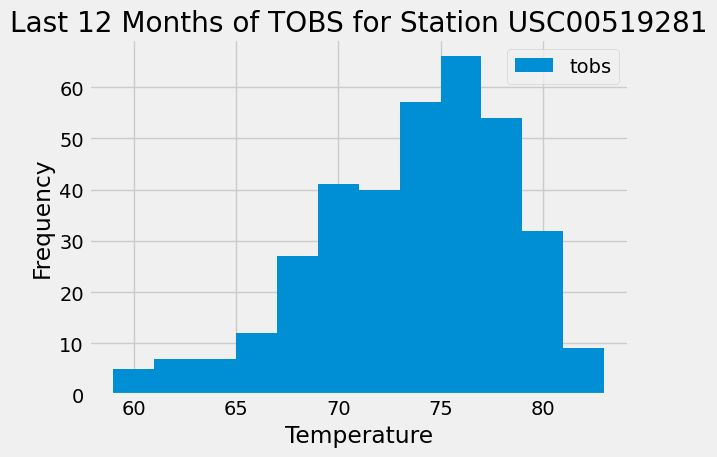

In [15]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

most_active_station_id = most_active_stations[0][0]

# Find the most recent date in the data set for the most active station
most_recent_date = session.query(Measurement.date).filter(Measurement.station == most_active_station_id)\
                    .order_by(Measurement.date.desc()).first()[0]

# Calculate the date one year from the last date in data set
one_year_ago = datetime.strptime(most_recent_date, '%Y-%m-%d') - timedelta(days=366)

# Query the last 12 months of temperature observation data for this station
temperature_data = session.query(Measurement.tobs)\
    .filter(Measurement.station == most_active_station_id)\
    .filter(Measurement.date >= one_year_ago).all()

# Extract the temperature observations
temperatures = [temp[0] for temp in temperature_data]

# Use Pandas to plot the results as a histogram
df_temps = pd.DataFrame(temperatures, columns=['tobs'])
df_temps.plot.hist(bins=12)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.title('Last 12 Months of TOBS for Station ' + most_active_station_id)
plt.tight_layout()
plt.show()


# Close Session

In [16]:
# Close Session
session.close()